In [1]:
from forecast_scoring import *

# Scoring Probability Forecasters
### How to test probabilistic predictions

Sander van Dijk @ Parkopedia

21 May 2019

# Probabilistic Forecasters

People want to know what will happen in the future. We look into crystal balls, coffee grounds, use tarrot cards, or read palms. Or, maybe more acceptable to some people, we try to extrapolate from past experience and available facts using logic, physics, or perhaps machine learning. A person or system that produces predictions about the future is a _forecaster_.

Some forecasters we encounter in our daily lifes:

* Bookies predicting the odds of sports outcomes (and adjusting them to their benefit)
* Pollsters guessing who will win the next election
* The weatherman forecasting the probability that it will rain tomorrow
* The probability of finding a parking space in an hour

If the forecast is a probability, like in the last two examples, we talk about a _probabilistic prediction_. 

# How good is a probability?

If somebody tells you the probability that something will occur, how can you test whether he is a good forecaster? Let's take the example of predicting whether it will rain tomorrow. For Tuesday, they make inverse predictions: 10% and 25%. With rain indeed falling on Monday and Tuesday being dry, they both predicted the correct outcome to be more likely than the wrong outcome. Anna would seem to be the better forecaster based on these two days, because she was more certain in her predictions. But what if the next two days they make similar predictions, but the outcomes are the exact inverse, meaning both did bad on those days. Anna now is more decisively wrong. But who is the better forecaster overall? And is either of them better than Carlos, who just predicted 50% all round, which is correct over all 4 days, but probably also not very useful.

Pick your favourite rain forecaster!

| Day | Anna | Robert | Carlos | Outcome |
|-----|------|-----|---------|---------|
| Monday    | 90% | 75% | 50% | 🌧️ |
| Tuesday   | 10% | 25% | 50% | 🌞 |
| Wednesday | 90% | 75% | 50% | 🌞 |
| Thursday  | 10% | 25% | 50% | 🌧️ |


# First observations
* It is not possible to answer:

    * Is this probability correct?
    * Is this forecaster accurate at 95%?
    
* Judgement should not be based on a small set of examples
* It is possible to debate about what a probability _means_... but we won't
* We _can_ develop some ideas about what makes a forecast useful and turn those into concrete tests

If you are interested in the philospy of the interpreteation of probabilities, you can make your way through [the entry on this topic in the Stanford Encyclopedia of Philosopyhy](https://plato.stanford.edu/entries/probability-interpret/). If you have heard the terms 'frequentist' and 'Baysian' before, you probably know why we won't touch that here..

# Intuition 1: Calibration

One of the first ideas that many people develop when talking about how good a probabilistic forecaster is, is often phrased along the lines of:

> Out of all the times you predicted something to happen with 70% chance, 
> it should indeed have happened 7 out of 10 times.

This idea is called 'calibration', and a forecaster who provides predictions that match the relative frequency of occurance in this way is said to be 'well calibrated.

# Calibration examples
* 11 jars; jar 1 has 10 red balls, jar 2: 1 green and 9 red, jar 3: 2 green, 8 red, et cetera
* Select jar, draw ball, note colour and forecaster's predicted probability

Let's look at an example. Imagine there are 11 jars, each containing 10 balls. The first jar only has red balls, the second has 1 green and 9 red balls, the third 2 green and 8 red, et cetera, until the last jar that contains only green balls. So, the probability that you would draw a green ball from the $k$th jar is $(k - 1) / 10$. The task of a forecaster here is to predict that probability.

First, assume the forecaster has no idea which jar is chosen to draw a ball from, and they decide to just output a random probability. If this is done many times, we can bin all outcomes by the given prediction, to get a feeling for how well they match up.

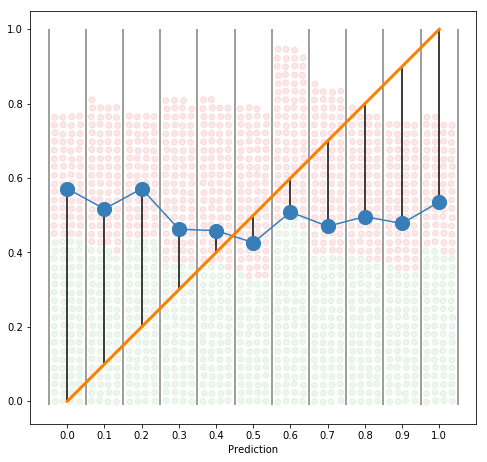

In [5]:
calibration_example("random", sort=True, calibration_line=True)

It is a bit easier to see what is going on when we sort the balls in each bin.

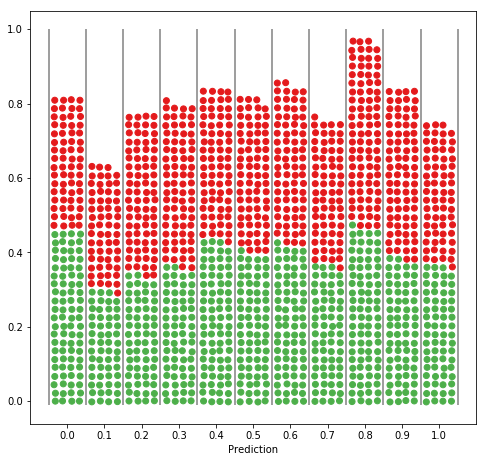

In [3]:
calibration_example("random", sort=True)

We see that the outcome is about 50-50 for each prediction bin, which makes sense given how the balls are distributed over the jars. Calculating the rate of green balls and plot that against the prediction is even clearer. This is called the 'calibration' curve, and if the forecaster is well calibrated, this would follow the diagonal, which is clearly not the case here.

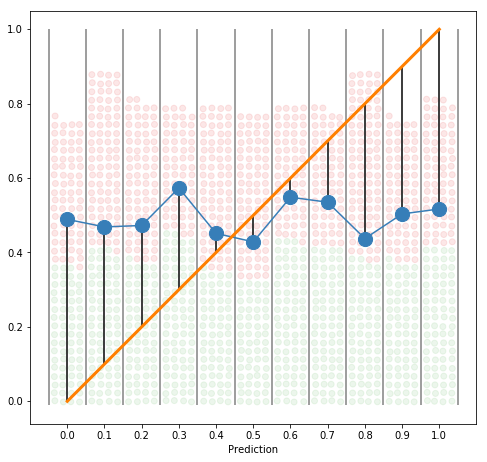

In [4]:
calibration_example("random", sort=True, calibration_line=True)

The black lines show how far the rate for each bin is from the ideal of perfect calibration.

Now lets consider a forecaster who knows which jar the next ball will be drawn from. He is able to use the known ratios of green balls per jar as the prediction to provide. For such a forecaster the calibration curve looks, not surpisingly, much better:

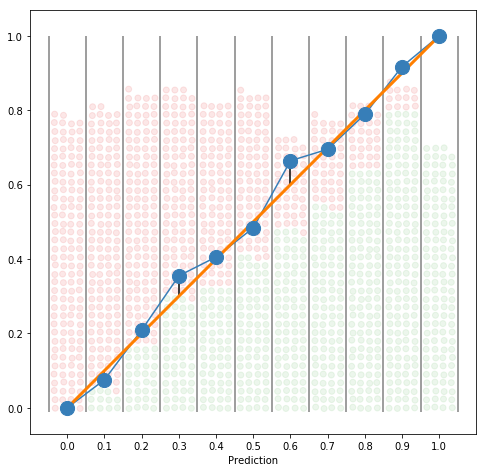

In [5]:
calibration_example("calibrated", sort=True, calibration_line=True)

# Calibration score

So, calibration is a desirable attribute of a good forecaster. We can turn this into a concrete measurement to compare different forecasters, based on the error lines seen above. If $f_k$ is the prediction assigned to bin $k$, and $\bar{o}_k$ is the ratio of positive outcomes in that bin, we have the per bin error $f_k - \bar{o}_k$, which is the length of the black lines. If we square this error to make it positive, and take the average over all observations in all bins, weighted by the number of observations in each bin to focus on more common predictions, we arrive at the callibration score:

$CAL = \frac{1}{N} \sum_{k=1}^{K} n_k (f_k - \bar{o}_k)^2$

Let's review the different forecasters and see what score they get.

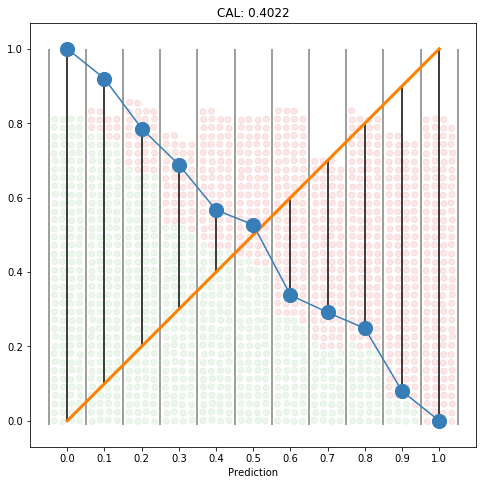

In [20]:
calibration_example("inverse", sort=True, calibration_line=True, calibration_score=True)

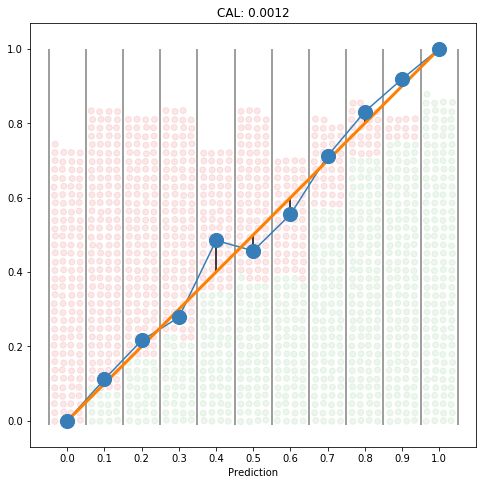

In [7]:
calibration_example("calibrated", sort=True, calibration_line=True, calibration_score=True)

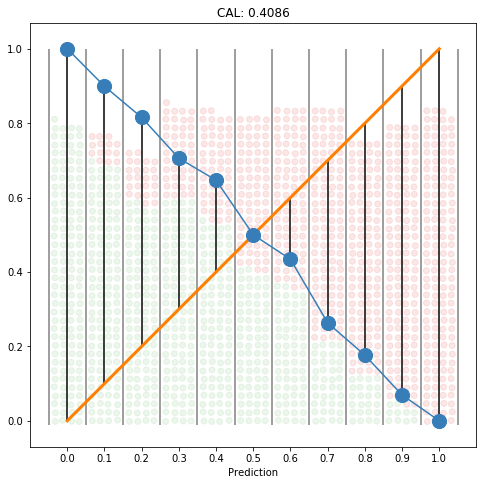

In [8]:
calibration_example("inverse", sort=True, calibration_line=True, calibration_score=True)

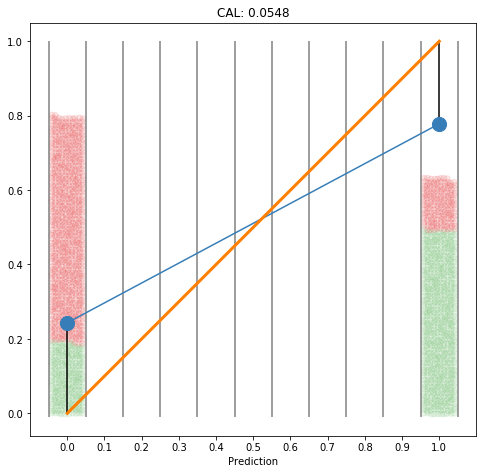

In [9]:
calibration_example("confident", sort=True, calibration_line=True, calibration_score=True)

So we see that a lower score is better, with a score of 0 meaning perfect calibration, and a perfectly inversely calibrated predictor scoring 0.4. It seems than that calibration is a useful metric to judge forecasters. However, let's see how Carlos would do, our forecaster that always says 50-50.

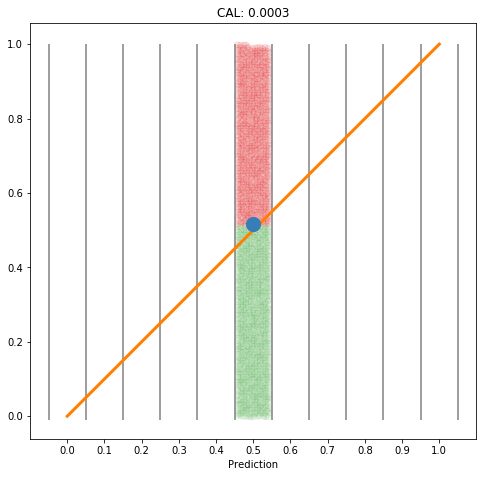

In [10]:
calibration_example("5050", sort=True, calibration_line=True, calibration_score=True)

He is perfectly calibrated! Do note that 50-50 works in this specific case, because that is the average rate over the whole set. In general, a forecaster that always predicts the overall sample rate, $\bar{o}$, achieves perfect calibration.

# Intuition 2: Resolution

So good calibration on its own does not guarantee a useful forecaster. We want one who doesn't just predict the sample rate, also called the _observed climatic average_, from a background in meteorology:

> A forecaster should be rewarded the more distinct its predictions are from the base rate

This is called the _resolution_ of the forecasts. In terms of the prediction bins we have been looking at so far, we can say that a high resolution means that the observed rate for each bin should be as far from the base rate as possible: we want the difference $\bar{o} - \bar{o}_k$ to be large (actually, far from zero). We can formulate a concrete score using this difference, analogous to how we derived the calibration score from the difference between prediction and observed rate:

$RES = \frac{1}{N} \sum_{k=1}^{K} n_k (\bar{o} - \bar{o}_k)^2$

# Resolution examples

Let's see how the forecasters we have seen perform on this new resolution score. Firtsly, the problematic 50-50 forecaster:

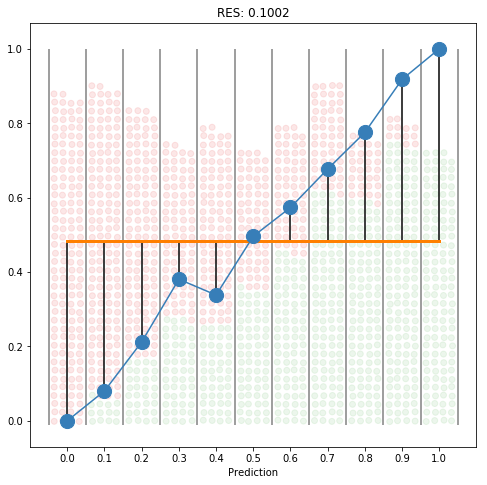

In [29]:
calibration_example("calibrated", sort=True, resolution_line=True, resolution_score=True)

He has no resolution at all. How about the other useless forecaster, the random one?

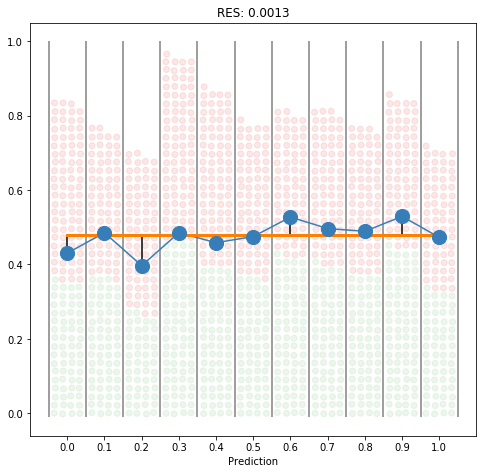

In [12]:
calibration_example("random", sort=True, resolution_line=True, resolution_score=True)

This one gets a little bit of resolution, but this is just due to some random fluctuations around the base rate. Our perfectly calibrated predictor hopefully fares better:

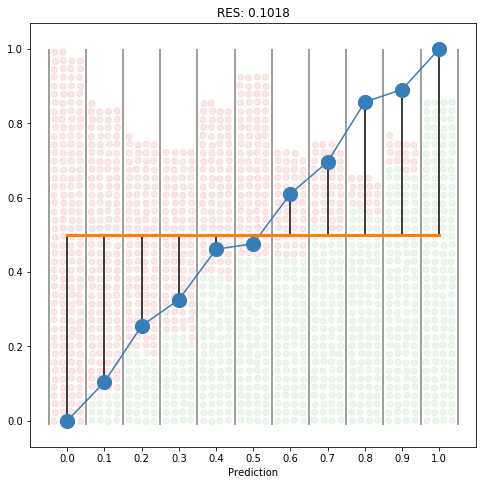

In [13]:
calibration_example("calibrated", sort=True, resolution_line=True, resolution_score=True)

# Putting things together

Target: **_minimise_ calibration loss while _maximising_ resolution**

<center>$\mathcal{L} = CAL - RES$</center>

<center>$ +~\bar{o} (1 - \bar{o})$</center>

<center>$=~\frac{1}{N} \sum_{t=1}^N (f_t - o_t)^2 = \mathcal{L}_{BRIER}$</center>

$\bar{o}(1 - \bar{o})$ is the _uncertainty_, $UNC$.

# Summary Brier decomposition

<center>$\large \mathcal{L}_{BRIER} = \frac{1}{N} \sum_{t=1}^N (f_t - o_t)^2 = CAL - RES + UNC$</center>

# Brier score is a proper score

A _proper_ score is one that:
* induces forecaster to report his true believes
* prevents 'hedging' of bets
* maximises reward when probabilities are used to make decisions with an unknown decision threshold

### Immediate optimisation target should be proper score

# Other proper scores

Infinite amount of proper scores; popular examples:
* Logarithmic loss - $\frac{1}{N} \sum_{t=1}^{N} \log {r_t}$
* Spherical loss - $\frac{1}{N} \sum_{t=1}^{N} \frac{r_t}{\sqrt(f_k^2 + (1 - f_k)^2}$
Scores differ in sensitivity to outliers and theoretical interpretations.

Not proper: linear loss - $\frac{1}{N} \sum_{t=1}^N | f_t - o_t |$
* Use of Mean Absolute Error causes prediction of median
* For probabilities: 0 if $f_k$ < 0.5 else 1

# Score interpretation through comparison
* Main question: what score is good (enough)?
* Interpret by comparing to alternatives
> How well am I doing relative to some reference forecaster?
* Can pick any reference available
    
    * Fully random forecaster
    * Same forecast throughout (Carlos)
    * A competitor
    * Previous version of forecast model
    * Climatic average over past

# Skill score: percentage improvement over reference

<center>$\large \text{SKILL} = 1 - \frac{\mathcal{L}}{\mathcal{L}_{ref}}$</center>

Examples:
* $\mathcal{L} = 0.1$, $\mathcal{L}_{ref} = 0.2$: loss reduces to half, $1 - 0.1/0.2 = 0.5$ ==> 50% improvement
* $\mathcal{L} = 0.2$, $\mathcal{L}_{ref} = 0.1$: loss doubled, $1 - 0.2/0.1 = -1$ ==> 100% worse

Skill score generally not proper
* **not optimisation target** but interpretation tool
* Infinite selection of references, infintie skill scores, each with different interpretation
* All options sensitive to small sample size, reference getting (un)lucky

# Special case: sample rate forecaster
* Forecaster happens to be ablle to predict sample rate, uses that as prediction throughout, i.e. $f_{ref} = \bar{o}$
* 'Best useless forecaster'
    * Can show: $\mathcal{L}_{ref} = \bar{o} (1 - \bar{o}) = UNC$

$\text{SKILL} = 1 - \frac{\mathcal{L}}{\mathcal{L}_{ref}} = 1 - \frac{CAL - RES + UNC}{UNC} = \frac{RES - CAL}{UNC}$

> A forecaster shows skill if her resolution outweighs calibration loss

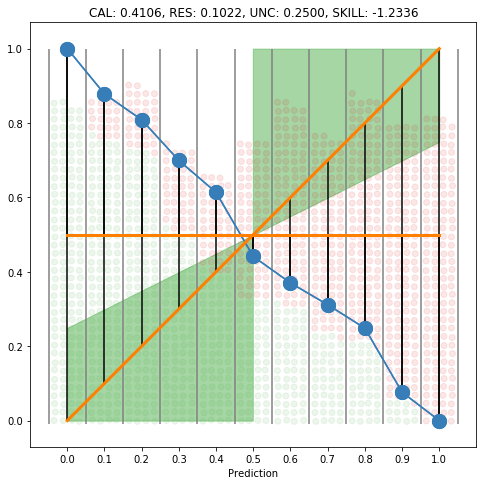

In [32]:
calibration_example("inverse", sort=True, calibration_line=True, resolution_line=True, skill_area=True, skill_score=True)

# Conclusions
* Brier score combines several intuitive ideas about what makes a useful forecaster
* Brier score is a proper score, target is to reduce this
* Brier skill score is a tool to interpret score